# Open spectrum from root-files
Author:

J. Angevaare // <j.angevaare@nikhef.nl> // 2020-05-25

Until now we have only been dealing with small files that make it easy to see what is going on. Perhaps we want at some point to get more data from the stoomboot computing cluster or the appended root-file as in this folder. This notebook will show how to and we make an exemplary coincidence plot for Ti-44 using much more data than in the previous tutorials.

Below we:
 - locate a file on the stoomboot computing cluster
 - open it using uproot
 - show a calibrated spectrum
 - show a Ti-44 coincidence plot

# (ONLY ON NIKEF CLUSTER)
## Locating file:
check where files live on stoomboot (NB: will only work on stoomboot not on your machine!)


In [1]:
import socket

In [2]:
def on_stoomboot():
    '''Check that you can do stuff here otherwise raise an error'''
    host = socket.gethostname()
    if not 'nikhef' in host:
        raise ValueError(f'You are not on stoomboot but on {host}. '
                          'You can not do this operation! Perhaps continue below')
        

In [3]:
# this is where files are stored (let's "grep" something from january this year)
on_stoomboot()
!ls /data/modulation/Raw_Data/combined/ | grep 202001

mx_n_20200104_1055
mx_n_20200106_0821
mx_n_20200110_0847
mx_n_20200114_0815
mx_n_20200117_0916
mx_n_20200120_0644
mx_n_20200124_1141


In [128]:
# this is where processed root files live, lets look at the top folder of the list above
on_stoomboot()
!ls -lthr /dcache/xenon/tmons/Modulation/processed/mx_n_20200104_1055 | tail -5

-rw-r--r--.  1 jorana xenon  80M Jan  6 11:01 mx_n_20200104_1055_000051.root
-rw-r--r--.  1 jorana xenon  80M Jan  6 11:02 mx_n_20200104_1055_000052.root
-rw-r--r--.  1 jorana xenon  80M Jan  6 11:02 mx_n_20200104_1055_000053.root
-rw-r--r--.  1 jorana xenon  80M Jan  6 11:03 mx_n_20200104_1055_000054.root
-rw-r--r--.  1 jorana xenon  38M Jan  6 11:03 mx_n_20200104_1055_000055.root


In [129]:
# Let's copy that last one as it is not too big
on_stoomboot()
!cp '/dcache/xenon/tmons/Modulation/processed/mx_n_20200104_1055/mx_n_20200104_1055_000055.root' ../data/.

In [130]:
on_stoomboot()
!ls -lthr ../data

total 5.5G
-rw-r--r--. 1 jorana xenon 3.9M Jun  7 21:33 Co60_sample.csv
drwxr-xr-x. 2 jorana xenon 4.0K Jun  7 22:01 bg
drwxr-xr-x. 2 jorana xenon 4.0K Jun  7 22:01 ti44
drwxr-xr-x. 2 jorana xenon 4.0K Jun  7 22:01 co60
drwxr-xr-x. 2 jorana xenon 4.0K Jun  7 22:01 cs137
-rw-r--r--. 1 jorana xenon  64M Jun  7 22:01 bg_dat.zip
-rw-r--r--. 1 jorana xenon 3.3G Jun  7 22:02 ti44_dat.zip
-rw-r--r--. 1 jorana xenon 843M Jun  7 22:02 co60_dat.zip
-rw-r--r--. 1 jorana xenon 1.3G Jun  7 22:02 cs137_dat.zip
drwxr-xr-x. 2 jorana xenon   80 Jun  7 22:36 copy_bg
-rw-r--r--. 1 jorana xenon  58K Jun  7 22:39 copy_bg.zip
-rw-r--r--. 1 jorana xenon  38M Jun  7 22:54 mx_n_20200104_1055_000055.root


# (EVERYWHERE)
## Open the data

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numba
import uproot

In [132]:
# Let's look at the first root file in the list above
path = '../data/mx_n_20200104_1055_000055.root'

In [133]:
file = uproot.open(path)

In [134]:
tree = file['T;2']

In [135]:
data = tree.pandas.df()

In [136]:
# Let's have a look at how the data looks like
data[['channel', 'integral', 'height', 'time', 'istestpulse', 'error', 'baseline', 'rms', 'ratio', 'humid', 'sec']]

,channel,integral,height,time,istestpulse,error,baseline,rms,ratio,humid,sec
entry,,,,,,,,,,,
0,5,1258.489746,0.756836,3.787286e+09,0,0,660.000000,8.000000,0.872195,-9.16,12510.0
1,6,1299.349243,1.729395,3.787286e+09,0,1,776.799988,2.993326,0.863694,-9.16,12510.0
2,2,1663.329346,0.942187,3.787286e+09,0,0,721.599976,8.236505,0.880226,-9.16,12510.0
3,3,543.199829,0.382129,3.787286e+09,0,0,661.599976,7.838367,0.861325,-9.16,12510.0
4,4,1328.034302,0.510059,3.787286e+09,0,0,769.599976,1.959592,0.899736,-9.16,12510.0
...,...,...,...,...,...,...,...,...,...,...,...
2329995,3,324.449554,0.265820,3.787288e+09,0,0,674.400024,4.079216,0.888982,-9.16,13742.0
2329996,2,332.196289,0.184961,3.787288e+09,0,0,720.799988,1.600000,0.915332,-9.16,13742.0
2329997,6,658.450928,0.876172,3.787288e+09,0,0,782.400024,6.499231,0.879627,-9.16,13742.0


## plot a spectrum of a source, we are starting with Co60!

In [137]:
mask =  (
    (data['channel'] == 4 ) | (data['channel'] == 5 ) 
    & (data['istestpulse'] == 0) 
    & (data['error'] == 0) 
)
co60 = data[mask]

In [138]:
co60

,channel,integral,height,time,istestpulse,error,baseline,rms,ratio,temp,...,humid,sec,hv0,hv1,hv2,hv3,hv4,hv5,hv6,hv7
entry,,,,,,,,,,,,,,,,,,,,,
0,5,1258.489746,0.756836,3.787286e+09,0,0,660.000000,8.000000,0.872195,29.4,...,-9.16,12510.0,619.099976,709.400024,679.400024,699.400024,989.299988,669.000000,659.0,729.099976
4,4,1328.034302,0.510059,3.787286e+09,0,0,769.599976,1.959592,0.899736,29.4,...,-9.16,12510.0,619.099976,709.400024,679.400024,699.400024,989.299988,669.000000,659.0,729.099976
9,4,1211.037231,0.442285,3.787286e+09,0,0,768.799988,5.306600,0.901098,29.4,...,-9.16,12510.0,619.099976,709.400024,679.400024,699.400024,989.299988,669.000000,659.0,729.099976
15,4,893.122253,0.337598,3.787286e+09,0,0,766.400024,5.425864,0.908753,29.4,...,-9.16,12510.0,619.099976,709.400024,679.400024,699.400024,989.299988,669.000000,659.0,729.099976
16,5,241.214294,0.177051,3.787286e+09,0,0,665.599976,3.200000,0.936039,29.4,...,-9.16,12510.0,619.099976,709.400024,679.400024,699.400024,989.299988,669.000000,659.0,729.099976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2329944,5,1685.615356,1.051758,3.787288e+09,0,0,664.000000,2.529822,0.873661,29.4,...,-9.16,13742.0,619.099976,709.400024,679.400024,699.400024,989.200012,668.900024,659.0,729.099976
2329954,4,1170.944702,0.427832,3.787288e+09,0,0,767.200012,2.993326,0.895789,29.4,...,-9.16,13742.0,619.099976,709.400024,679.400024,699.400024,989.200012,668.900024,659.0,729.099976
2329955,5,454.636932,0.289746,3.787288e+09,0,0,662.400024,1.959592,0.899825,29.4,...,-9.16,13742.0,619.099976,709.400024,679.400024,699.400024,989.200012,668.900024,659.0,729.099976


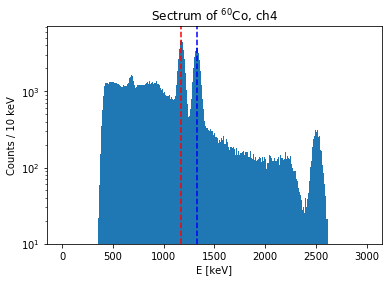

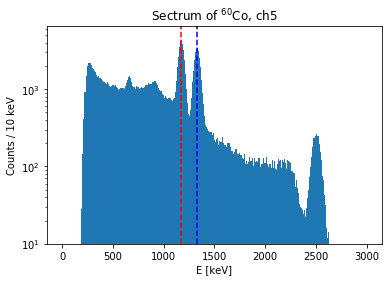

In [139]:
for ch in np.unique(co60['channel']):
    plt.title('Sectrum of ${}^{60}$Co'f', ch{ch}')
    selection = (co60['channel']==ch)
    plt.hist(co60[selection]['integral'].values, bins = 300, range=[0,3000])
    plt.yscale('log')
    plt.ylim(10,plt.ylim()[-1])
    plt.axvline(1173.2, c = 'r', linestyle = '--')
    plt.axvline(1332.5, c = 'b', linestyle = '--')
    plt.xlabel('E [keV]')
    plt.ylabel('Counts / 10 keV')
    plt.show()

## Save small selection
For further use cases we want to save a copy where we have somewhat less data such that we can use this to do small tests with.

This is actually where the CSV file that was used in the previous tutorials was created. You can see that we have capped the max number of events in this file to 100000.

In [140]:
co60[['channel', 'integral','time']][:100000].to_csv('../data/Co60_sample.csv',index=False)

# Ti44

Below, we'll do the same thing as we have done earlier for Co60 in the 3rd session. Now we'll do the same for Ti44 but with much higher statistics!

Can you again explain all of the spectrum we will see below? Good luck!

In [16]:
from coincidence_matching import *

In [17]:
# Let's cut out some data where we are not interested in anyway
mask =  ((data['istestpulse'] == 0)  & (data['error'] == 0) )
data = data[mask]

In [18]:
print(f'Pay attention, we are going to go through quite a lot of data!\n'
      f'The data we are using now is a staggering {len(data)} events (that is ~{int(len(data)/1e6)} million!)')

Pay attention, we are going to go through quite a lot of data!
The data we are using now is a staggering 2293930 events (that is ~2 million!)


In [19]:
%%time
matched_ti44 = easy_coincidence_matching(data, source='Ti44', check_time_order = False)

CPU times: user 3.05 s, sys: 2.13 s, total: 5.18 s
Wall time: 3.6 s


In [20]:
%%time
matched_ti44 = easy_coincidence_matching(data, source='Ti44', check_time_order = False)

CPU times: user 954 ms, sys: 150 ms, total: 1.1 s
Wall time: 1.1 s


In [21]:
matched_ti44

,e_ch2,e_ch3,t_ch2,t_ch3
0,1663.329346,543.199829,3.787286e+09,3.787286e+09
1,501.850494,534.243225,3.787286e+09,3.787286e+09
2,668.394592,302.602966,3.787286e+09,3.787286e+09
3,584.177307,1112.822632,3.787286e+09,3.787286e+09
4,1211.873535,651.058533,3.787286e+09,3.787286e+09
...,...,...,...,...
397110,513.559204,848.104431,3.787288e+09,3.787288e+09
397111,500.447906,520.831970,3.787288e+09,3.787288e+09
397112,528.500000,391.742767,3.787288e+09,3.787288e+09
397113,534.476318,517.040833,3.787288e+09,3.787288e+09


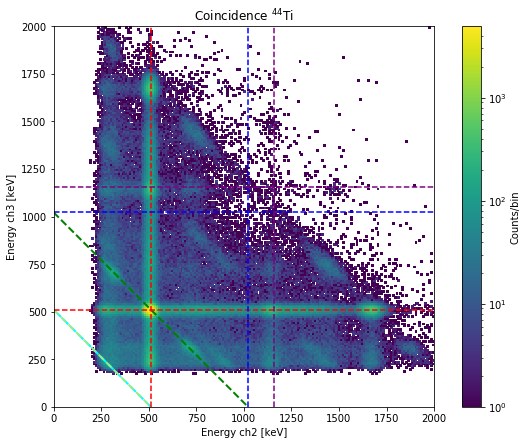

In [22]:
plt.figure(figsize=(10,7))
plt.hist2d(
    matched_ti44['e_ch2'],
    matched_ti44['e_ch3'], 
    bins = 200, 
    norm=LogNorm(),
    range=[[0,2000],[0,2000]]);
plt.plot([511,0], [0,511], linestyle = '--', linewidth = 2, c = 'cyan')
plt.plot([0,511], [511,0], linestyle = '--', linewidth = 2, c = 'lightgreen')
plt.plot([0,511+511], [511+511,0], linestyle = '--', linewidth = 2, c = 'green')
plt.gca().set_aspect(1)
plt.colorbar(label='Counts/bin')
plt.xlabel('Energy ch2 [keV]')
plt.ylabel('Energy ch3 [keV]')
plt.title('Coincidence ${}^{44}$Ti');
plt.axvline(511, c = 'r', linestyle = '--')
plt.axhline(511, c = 'r', linestyle = '--')
plt.axvline(511*2, c = 'b', linestyle = '--')
plt.axhline(511*2, c = 'b', linestyle = '--')
plt.axvline(1157, c = 'purple', linestyle = '--', label = '1157 keV')
plt.axhline(1157, c = 'purple', linestyle = '--', label = '1157 keV')

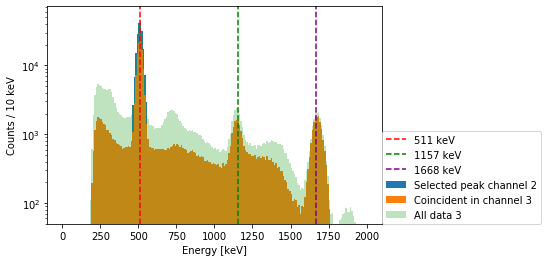

In [23]:
selected_data = select_peak(matched_ti44, 'e_ch2', energy = 511, energy_range = 50)
plt.hist(selected_data['e_ch2'], bins = 200, range=[0,2000], label = 'Selected peak channel 2')
plt.hist(selected_data['e_ch3'], bins = 200, range=[0,2000], label = 'Coincident in channel 3')
plt.hist(matched_ti44['e_ch3'], bins = 200, range=[0,2000], label = 'All data 3', alpha = 0.3)
plt.axvline(511, c = 'r', linestyle = '--', label = '511 keV')
plt.axvline(1157, c = 'green', linestyle = '--', label = '1157 keV')
plt.axvline(1157+511, c = 'purple', linestyle = '--', label = f'{1157+511} keV')
plt.yscale('log')
plt.legend(loc=(1,0))
plt.xlabel('Energy [keV]')
plt.ylabel('Counts / 10 keV')
plt.ylim(ymin=50);

## (BONUS)
### Generate very large files
As you may have seen above, this is only one of the many files we have available (there is about 50 TB so more than you want to imagine). Below, we will show what you can do to get more data but be aware, this may not be required, will take more time and make your computer unhappy.


In [122]:
# Load some packages
import os
import tqdm
import socket

In [52]:
# Load all the data  on this path
# NB: only works on stoomboot!
# NB: takes 20 minutes!
on_stoomboot()
root_folder = '/dcache/xenon/tmons/Modulation/processed/mx_n_20200104_1055'
store_columns = ['channel', 'integral','time']
sources = {'bg':[0,1], 'ti44':[2,3], 'co60':[4,5], 'cs137':[6,7]}
for root_file in tqdm.tqdm(os.listdir(root_folder)):
    if not '.root' in root_file:
        # This is not a rootfile
        continue
    else:
        idx = root_file.split('_')[-1].split('.root')[0]
    path = os.path.join(root_folder, root_file)
    file = uproot.open(path)
    tree = file['T;2']
    data = tree.pandas.df()
    for source, channels in sources.items():
        mask = ( 
            (data['channel'] == channels[0] ) | (data['channel'] == channels[1] ) 
            & (data['istestpulse'] == 0) 
            & (data['error'] == 0) 
        )
        save_dir = f'../data/{source}}'
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_name = f'{save_dir}/{source}_chunck_{idx}.csv'
        data[mask][store_columns].to_csv(save_name,index=False)
    # Double check that we free up memory
    del data, mask

100%|██████████| 58/58 [19:28<00:00, 20.15s/it]


In [53]:
# Alright, let me zip this data for you. After that you can download it on your own laptop
import zipfile

In [56]:
# Let's zip al the dat a in these files
on_stoomboot()
for source in sources.keys():
    save_dir = f'../data/{source}'
    zipObj = zipfile.ZipFile(f'../data/{source}_dat.zip', 'w')
    for f in tqdm.tqdm(os.listdir(save_dir)):
        if '.csv' in f:
            path = os.path.join(save_dir, f)
            zipObj.write(path)

100%|██████████| 56/56 [00:08<00:00,  6.85it/s]


In [63]:
# Great our data is zipped and at:
!ls ../data | grep zip

bg_dat.zip
co60_dat.zip
cs137_dat.zip
ti44_dat.zip


### Downloading this data:
This may take a while as it is ~5 GB of data. You can download the data from:

  - https://drive.google.com/file/d/1rTw_5nmkb25eWifcunZVIc929zyBRKlf/view?usp=sharing (BG)
  - https://drive.google.com/file/d/1JiJyOY5Dgnjj4FATxeTA1MrTh2e8ZndH/view?usp=sharing (Co60)
  - https://drive.google.com/file/d/1KpKKrpYwQKo0f1MhMSg9JRrJcXniKw1X/view?usp=sharing (Cs137)
  - https://drive.google.com/file/d/1YVLQdRIQjF_1abRqU3QjhIvc0pNb-_ra/view?usp=sharing (Ti44)


## Generate huge dataframes (high statistics)
### WARNING:
unproper handing may result in high RAM usage and performance loss

I assume you have downloaded **and extracted** the zip files (see above) and the data is stored under ``/data/...``

## Ti44

In [83]:
save_dir = f'../data/ti44'

In [84]:
# Great we have the data where we expected it!
!ls $save_dir

ti44_chunck_000000.csv	ti44_chunck_000019.csv	ti44_chunck_000038.csv
ti44_chunck_000001.csv	ti44_chunck_000020.csv	ti44_chunck_000039.csv
ti44_chunck_000002.csv	ti44_chunck_000021.csv	ti44_chunck_000040.csv
ti44_chunck_000003.csv	ti44_chunck_000022.csv	ti44_chunck_000041.csv
ti44_chunck_000004.csv	ti44_chunck_000023.csv	ti44_chunck_000042.csv
ti44_chunck_000005.csv	ti44_chunck_000024.csv	ti44_chunck_000043.csv
ti44_chunck_000006.csv	ti44_chunck_000025.csv	ti44_chunck_000044.csv
ti44_chunck_000007.csv	ti44_chunck_000026.csv	ti44_chunck_000045.csv
ti44_chunck_000008.csv	ti44_chunck_000027.csv	ti44_chunck_000046.csv
ti44_chunck_000009.csv	ti44_chunck_000028.csv	ti44_chunck_000047.csv
ti44_chunck_000010.csv	ti44_chunck_000029.csv	ti44_chunck_000048.csv
ti44_chunck_000011.csv	ti44_chunck_000030.csv	ti44_chunck_000049.csv
ti44_chunck_000012.csv	ti44_chunck_000031.csv	ti44_chunck_000050.csv
ti44_chunck_000013.csv	ti44_chunck_000032.csv	ti44_chunck_000051.csv
ti44_chunck_000014.csv	ti44_chunck

In [85]:
# Let's make one giant array of pandas dataframes. We will combine them in a second
combined = []
for f in tqdm.tqdm(os.listdir(save_dir)):
    path = os.path.join(save_dir, f)
    combined.append(pd.read_csv(path))

100%|██████████| 56/56 [00:30<00:00,  1.82it/s]


In [86]:
%%time
combined_ti44 = pd.concat(combined)

In [87]:
combined_ti44

,channel,integral,time
0,3,368.18967,3.787213e+09
1,2,496.53372,3.787213e+09
2,2,528.36320,3.787213e+09
3,3,889.49756,3.787213e+09
4,2,1116.11150,3.787213e+09
...,...,...,...
2087389,2,1674.10350,3.787212e+09
2087390,2,1358.18650,3.787212e+09
2087391,3,849.32043,3.787212e+09
2087392,2,498.78986,3.787212e+09


Wow! That is 116 **million** events, that is a lot! Things will take longer to compute.

In [89]:
%%time
# Notice that we do have to check the time ordering as the csv-files are loaded in a random order
matched_ti44 = easy_coincidence_matching(combined_ti44, source='Ti44', check_time_order = True)

Checking time order of your data. This can take a while. Disable with check_time_order = False
Warning! Your data was not time ordered, doing that now. May take a while
CPU times: user 1min 31s, sys: 12.3 s, total: 1min 43s
Wall time: 1min 43s


CPU times: user 24.5 s, sys: 3.28 s, total: 27.7 s
Wall time: 27.7 s


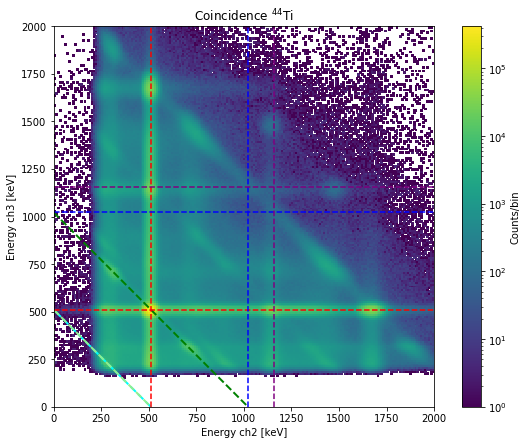

In [90]:
%%time
plt.figure(figsize=(10,7))
plt.hist2d(
    matched_ti44['e_ch2'],
    matched_ti44['e_ch3'], 
    bins = 200, 
    norm=LogNorm(),
    range=[[0,2000],[0,2000]]);
plt.plot([511,0], [0,511], linestyle = '--', linewidth = 2, c = 'cyan')
plt.plot([0,511], [511,0], linestyle = '--', linewidth = 2, c = 'lightgreen')
plt.plot([0,511+511], [511+511,0], linestyle = '--', linewidth = 2, c = 'green')
plt.gca().set_aspect(1)
plt.colorbar(label='Counts/bin')
plt.xlabel('Energy ch2 [keV]')
plt.ylabel('Energy ch3 [keV]')
plt.title('Coincidence ${}^{44}$Ti');
plt.axvline(511, c = 'r', linestyle = '--')
plt.axhline(511, c = 'r', linestyle = '--')
plt.axvline(511*2, c = 'b', linestyle = '--')
plt.axhline(511*2, c = 'b', linestyle = '--')
plt.axvline(1157, c = 'purple', linestyle = '--', label = '1157 keV')
plt.axhline(1157, c = 'purple', linestyle = '--', label = '1157 keV')

### Co60
we can do the same trick again

In [112]:
save_dir = f'../data/co60'

In [113]:
# Great we have the data where we expected it!
!ls $save_dir

co60_chunck_000000.csv	co60_chunck_000019.csv	co60_chunck_000038.csv
co60_chunck_000001.csv	co60_chunck_000020.csv	co60_chunck_000039.csv
co60_chunck_000002.csv	co60_chunck_000021.csv	co60_chunck_000040.csv
co60_chunck_000003.csv	co60_chunck_000022.csv	co60_chunck_000041.csv
co60_chunck_000004.csv	co60_chunck_000023.csv	co60_chunck_000042.csv
co60_chunck_000005.csv	co60_chunck_000024.csv	co60_chunck_000043.csv
co60_chunck_000006.csv	co60_chunck_000025.csv	co60_chunck_000044.csv
co60_chunck_000007.csv	co60_chunck_000026.csv	co60_chunck_000045.csv
co60_chunck_000008.csv	co60_chunck_000027.csv	co60_chunck_000046.csv
co60_chunck_000009.csv	co60_chunck_000028.csv	co60_chunck_000047.csv
co60_chunck_000010.csv	co60_chunck_000029.csv	co60_chunck_000048.csv
co60_chunck_000011.csv	co60_chunck_000030.csv	co60_chunck_000049.csv
co60_chunck_000012.csv	co60_chunck_000031.csv	co60_chunck_000050.csv
co60_chunck_000013.csv	co60_chunck_000032.csv	co60_chunck_000051.csv
co60_chunck_000014.csv	co60_chunck

In [114]:
# Let's make one giant array of pandas dataframes. We will combine them in a second
combined = []
for f in tqdm.tqdm(os.listdir(save_dir)):
    path = os.path.join(save_dir, f)
    combined.append(pd.read_csv(path))

100%|██████████| 56/56 [00:08<00:00,  6.45it/s]


In [116]:
%%time
combined_co60 = pd.concat(combined)

CPU times: user 134 ms, sys: 402 ms, total: 536 ms
Wall time: 535 ms


In [117]:
combined_co60

,channel,integral,time
0,5,1146.97720,3.787213e+09
1,4,852.68646,3.787213e+09
2,4,1605.72160,3.787213e+09
3,4,1159.78550,3.787213e+09
4,4,1278.30700,3.787213e+09
...,...,...,...
527551,4,1658.74200,3.787212e+09
527552,5,493.04890,3.787212e+09
527553,5,2213.53520,3.787212e+09
527554,5,260.83258,3.787212e+09


In [120]:
%%time
# Notice that we do have to check the time ordering as the csv-files are loaded in a random order
matched_co60 = easy_coincidence_matching(combined_co60, source='Co60', check_time_order = True)

Checking time order of your data. This can take a while. Disable with check_time_order = False
Warning! Your data was not time ordered, doing that now. May take a while
CPU times: user 21 s, sys: 1.68 s, total: 22.7 s
Wall time: 22.7 s


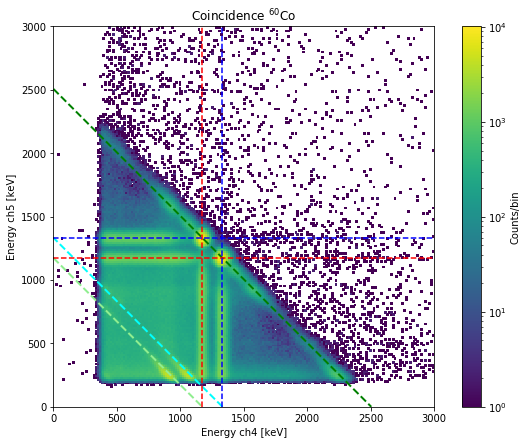

In [121]:
plt.figure(figsize=(10,7))
plt.hist2d(
    matched_co60['e_ch4'],
    matched_co60['e_ch5'], 
    bins = 200, 
    norm=LogNorm(),
    range=[[0,3000],[0,3000]]);
plt.plot([1332.5,0], [0,1332.5], linestyle = '--', linewidth = 2, c = 'cyan')
plt.plot([0,1173.2], [1173.2,0], linestyle = '--', linewidth = 2, c = 'lightgreen')
plt.plot([0,1173.2+1332.5], [1173.2+1332.5,0], linestyle = '--', linewidth = 2, c = 'green')
plt.gca().set_aspect(1)
plt.colorbar(label='Counts/bin')
plt.xlabel('Energy ch4 [keV]')
plt.ylabel('Energy ch5 [keV]')
plt.title('Coincidence ${}^{60}$Co');
plt.axvline(1173.2, c = 'r', linestyle = '--')
plt.axhline(1173.2, c = 'r', linestyle = '--')
plt.axvline(1332.5, c = 'b', linestyle = '--')
plt.axhline(1332.5, c = 'b', linestyle = '--')